In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import math
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
plt.style.use('seaborn')
%matplotlib inline

# Interpolation of calibration curves

Can we use linear interpolation of calibration curves to "correct" spectra with the etalonning effect?

In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp
    
def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp
    
def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal
    
def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal
    
def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves
    
def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves
    
def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs
    
def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw
    
def get_ftir_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer2/timestamps'][:]
        return timestamps
    
def get_visible_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer1/timestamps'][:]
        return timestamps
    
def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs
    
def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertion_keys = list(h5_file[calibration_path].keys())
        insertions = [f'{calibration_path}/{key}' for key in insertion_keys]            
        return insertions
    
def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def construct_full_file_path(data_path, file_name):
    file_path = data_path + file_name
    return file_path

def create_list_of_sessions_in_file(file_name):
    sessions = []
    all_groups = create_list_of_items_in_node("group", file_name, "/")
    for group in all_groups:
        if (group[0:3] == 'ses') and (len(group) == 10):
            sessions.append(group)
    return sessions

def create_list_of_insertions_in_file(file_name):
    insertions = []
    sessions = create_list_of_sessions_in_file(file_name)
    for session in sessions:
        calibrations = create_list_of_calibrations_in_node(file_name, session)
        for calibration in calibrations:
            cal_insertions = create_list_of_insertions_in_calibration(file_name, calibration)
            for insertion in cal_insertions:
                insertions.append(insertion)
    return insertions
            
def get_insertion_timestamp(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_time = h5_file[insertion_path].attrs['start_time']
        ins_timestamp = pd.Timestamp(ins_time, unit='us')
        return ins_timestamp
    
def get_calibration_timestamp(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_time = h5_file[calibration_path].attrs['calibration_start_time']
        cal_timestamp = pd.Timestamp(cal_time, unit='us')
        return cal_timestamp  
    
def find_position_in_wavelength_vector(wavelength_vector, integer):
    position = np.where(np.isclose(wavelength_vector, integer, 1e-3))[0][0]
    return position

def normalize(value, max_value, min_value):
    normalized_value = (value - min_value)/(max_value - min_value)
    return normalized_value

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal
    
def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal
        
def get_ftir_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer2/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp
    
def get_visible_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer1/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp
    
def compute_3D_distance(x1, y1, z1, x2, y2, z2):
    distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return distance

def calculate_wavenumbers_from_wavelengths(wavelength_vector):
    return 10000000/wavelength_vector

def put_spectrum_in_wavenum_order(spectrum):
    return np.flip(spectrum)

# Interpolation of white test blank spectra

I start with an "insertion" of white test blank spectra.  I will try to interpolated corrected spectra based on the last white test blank spectrum of the previous insertion and the first white test blank spectrum of the following insertion.

In [3]:
# I have chosen to use an insertion from 4/26/21

path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

df = pd.read_csv('data/white_insertions_210503.csv')
date = '4/26/21'
date_df = df.loc[df['date'] == date].copy()
small_df = date_df.loc[date_df['i_unique'] == 'c024i05']
small_df

file_name     date     session  \
137  210426_green_tests/green_testing_210426.h5  4/26/21  session002   

    calibration insertion c_unique i_in_c i_unique    conditions  
137      cal002    ins015     c024    i05  c024i05  sunshine box

In [4]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
# this part retrieves the relevant data
for index in small_df.index.values:
    file_name = small_df['file_name'][index]
    file = path_name + file_name
    cal_path = small_df['session'][index] + "/" + small_df['calibration'][index]
    insertion_path = cal_path + "/" + small_df['insertion'][index]
    raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)
    absorbances = get_ftir_insertion_absorbances(file, insertion_path)
    timestamps = get_ftir_insertion_timestamps(file, insertion_path)
    waves = get_ftir_wavelength_vector(file, cal_path)

# this gets the timestamps in Timestamp format
ts = []
for i in range(timestamps.shape[0]):
    timestamp = pd.Timestamp(timestamps[i], unit='us')
    ts.append(timestamp)

## A plot of the input raw spectra from the chosen insertion

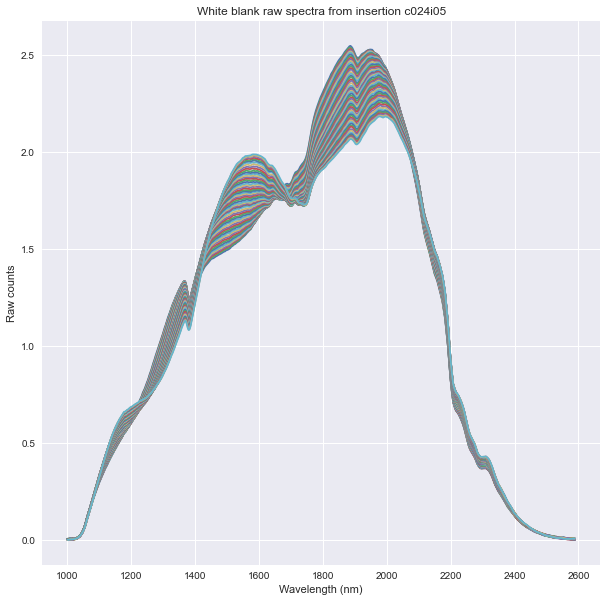

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("White blank raw spectra from insertion c024i05")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Raw counts")
for i in range(raw_spectra.shape[0]):
    ax.plot(waves, raw_spectra[i, :])
plt.show()
plt.close()
    

## A plot of the original absorbances calculated for the chosen insertion

These are simply extracted from the data file and plotted.

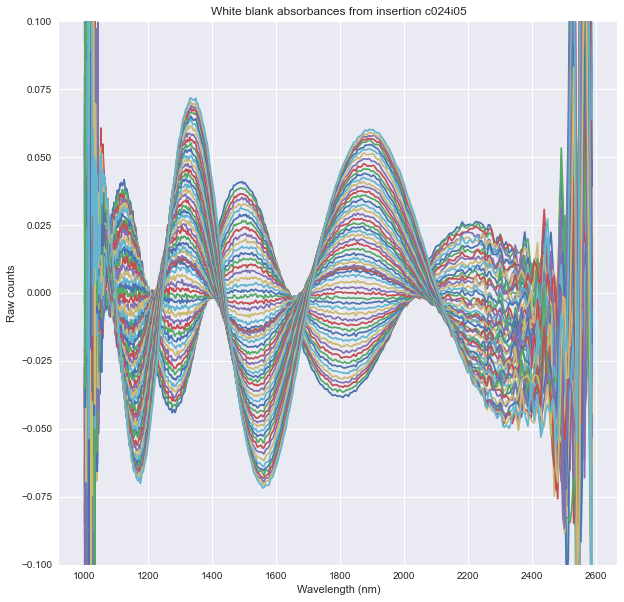

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("White blank absorbances from insertion c024i05")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Raw counts")
ax.set_ylim(-0.1, 0.1)
for i in range(absorbances.shape[0]):
    ax.plot(waves, absorbances[i, :])
plt.show()
plt.close()

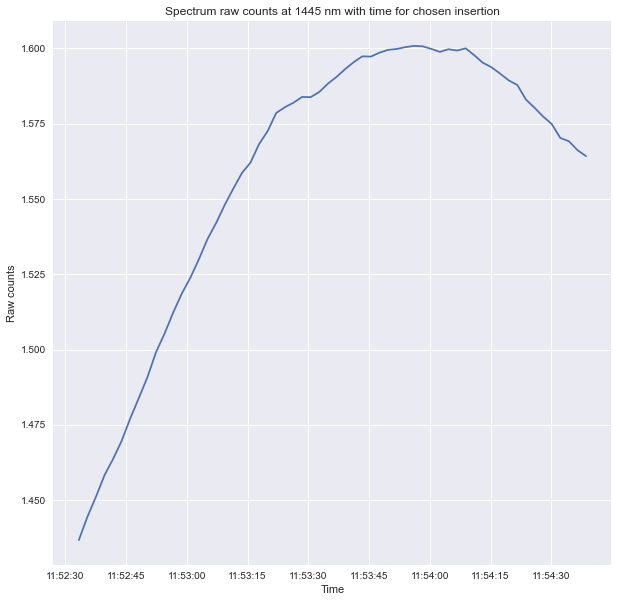

In [7]:
# This is to show how the raw counts changes with time over the course of the insertion

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(ts, raw_spectra[:, 350])
ax.set_title("Spectrum raw counts at 1445 nm with time for chosen insertion")
ax.set_xlabel("Time")
ax.set_ylabel("Raw counts")
plt.show()
plt.close()

In [8]:
# extracting the spectra that will be used as the "calibration" spectra to interpolate between
first_spectrum = raw_spectra[0, :]
last_spectrum = raw_spectra[-1, :]

# the timestamps for the first and last spectra
first_time = ts[0]
last_time = ts[-1]

In [9]:
# create the dataframe, indexed on the timestamps
try2 = pd.DataFrame(index=ts, columns=np.arange(0, waves.shape[0], 1), dtype=float)

# put the first and last spectra in the first and last rows of the dataframe
try2.iloc[0, :] = first_spectrum
try2.iloc[-1, :] = last_spectrum

# interpolate at each timestamp between the first and the last
output = try2.interpolate().copy()

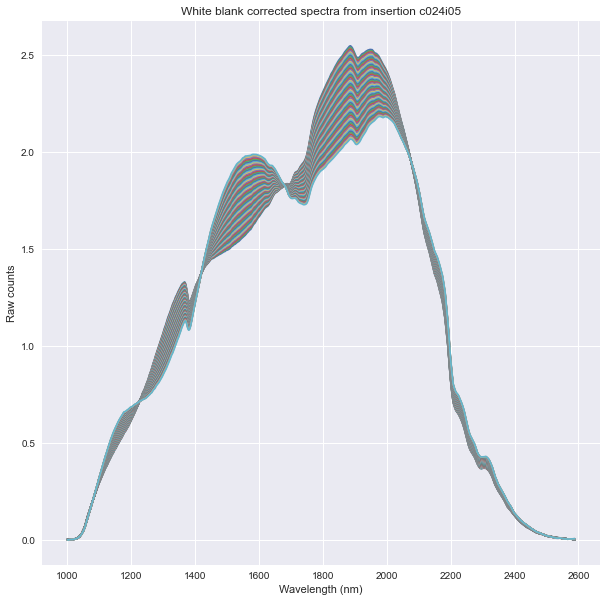

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("White blank corrected spectra from insertion c024i05")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Raw counts")
for i in range(try2.shape[0]):
    ax.plot(waves, output.iloc[i, :])
plt.show()
plt.close()

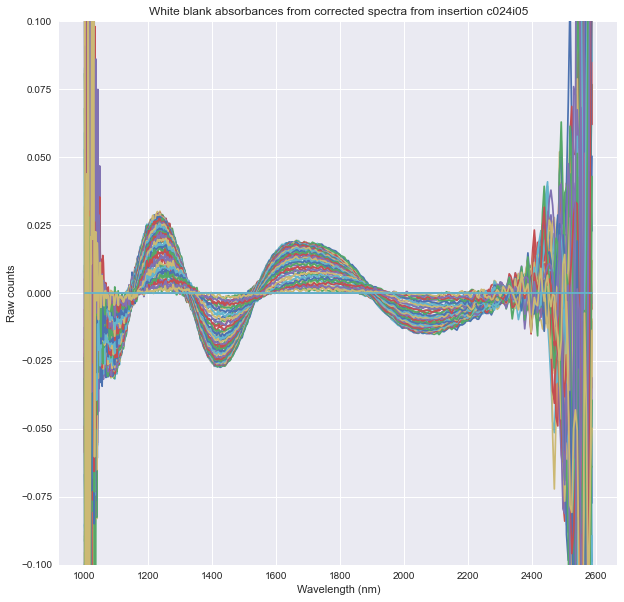

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("White blank absorbances from corrected spectra from insertion c024i05")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Raw counts")
ax.set_ylim(-0.1, 0.1)
for i in range(try2.shape[0]):
    absorbance = calculate_absorbance_from_raw(raw_spectra[i, :], output.iloc[i, :], 0)
    ax.plot(waves, absorbance)
plt.show()
plt.close()

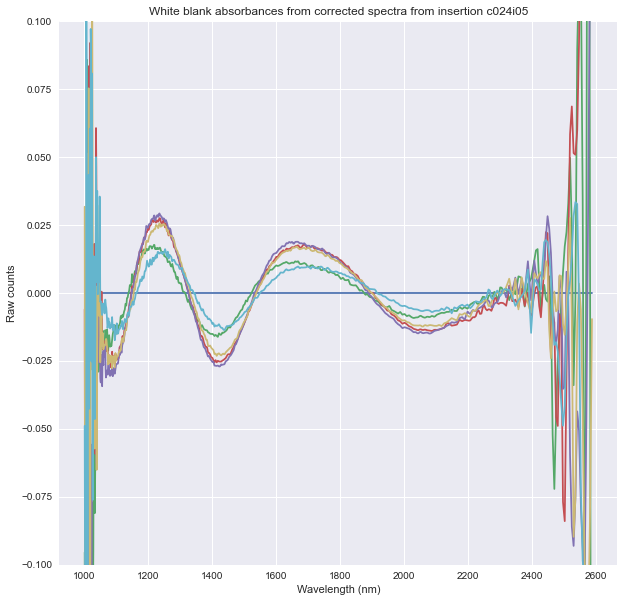

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("White blank absorbances from corrected spectra from insertion c024i05")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Raw counts")
ax.set_ylim(-0.1, 0.1)
for i in range(0, try2.shape[0], 10):
    absorbance = calculate_absorbance_from_raw(raw_spectra[i, :], output.iloc[i, :], 0)
    ax.plot(waves, absorbance)
plt.show()
plt.close()

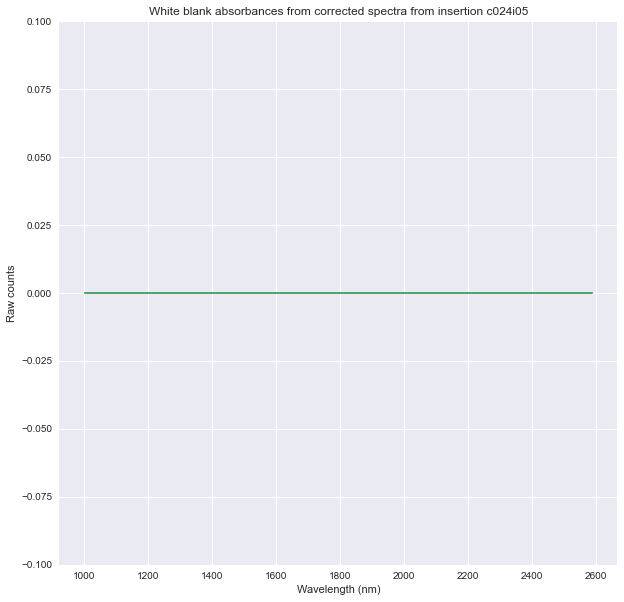

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("White blank absorbances from corrected spectra from insertion c024i05")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Raw counts")
ax.set_ylim(-0.1, 0.1)
absorbance_first = calculate_absorbance_from_raw(raw_spectra[0, :], output.iloc[0, :], 0)
absorbance_last = calculate_absorbance_from_raw(raw_spectra[-1, :], output.iloc[-1, :], 0)

ax.plot(waves, absorbance_first)
ax.plot(waves, absorbance_last)
plt.show()
plt.close()

# Correcting soil sample spectra

Now to apply the previous method to spectra of a sample, and use the interpolation to correct the spectra as they were taken.  The samples in this case are of a single soil sample, taken repeatedly over the course of a few minutes.

Immediately before the soil sample "insertion" I had taken an "insertion" of white test blank samples.  Similarly, another insertion of white test blank samples was taken following the the soil sample insertion.  The last spectrum and first spectrum from these insertions, respectively, was used as the source of the interpolated corrected calibration curves.

In [14]:
# getting the data
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = '210422_green_tests/green_testing_210422.h5'
file = path_name + file_name
cal_path = 'session002/cal003'
soil_insertion_path = 'session002/cal003/ins020'
previous_white_blank_path = 'session002/cal003/ins019'
following_white_blank_path = 'session002/cal003/ins021'

soil_absorbances = get_ftir_insertion_absorbances(file, soil_insertion_path)
soil_timestamps = get_ftir_insertion_timestamps(file, soil_insertion_path)
soil_raw_spectra = get_ftir_insertion_raw_spectra(file, soil_insertion_path)

previous_white_spectra = get_ftir_insertion_raw_spectra(file, previous_white_blank_path)
previous_timestamps = get_ftir_insertion_timestamps(file, previous_white_blank_path)
following_white_spectra = get_ftir_insertion_raw_spectra(file, following_white_blank_path)
following_timestamps = get_ftir_insertion_timestamps(file, following_white_blank_path)

waves = get_ftir_wavelength_vector(file, cal_path)

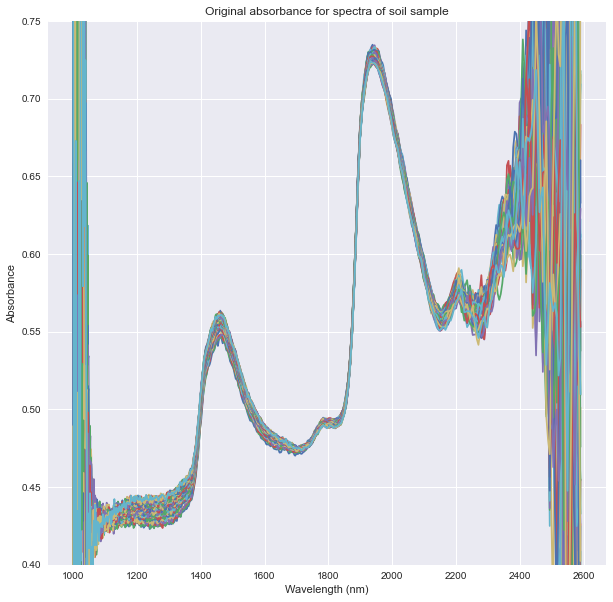

In [15]:
# plot of the orginal absorbances

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Original absorbance for spectra of soil sample")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absorbance")
ax.set_ylim(0.4, 0.75)
for i in range(soil_absorbances.shape[0]):
    ax.plot(waves, soil_absorbances[i, :])
plt.show()
plt.close()

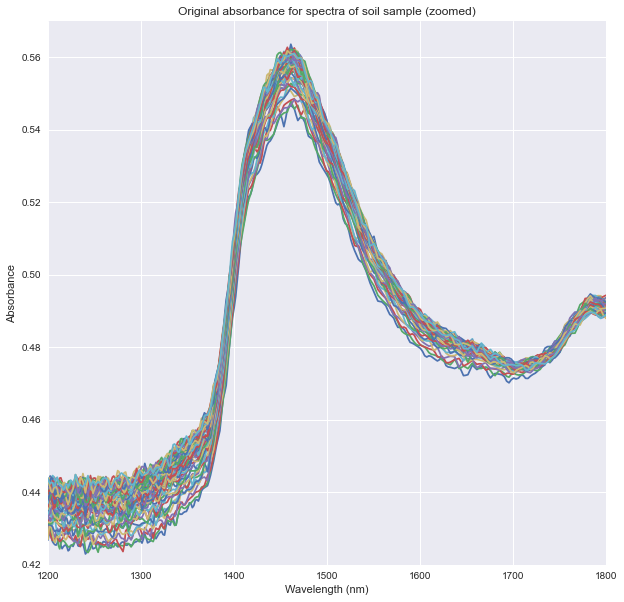

In [16]:
# Zoomed in absorbance for soil sample
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Original absorbance for spectra of soil sample (zoomed)")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absorbance")

ax.set_ylim(0.42, 0.57)
ax.set_xlim(1200, 1800)
for i in range(soil_absorbances.shape[0]):
    ax.plot(waves, soil_absorbances[i, :])
plt.show()
plt.close()

In [17]:
# select the appropriate white test blank spectra to use as calibrations
previous_white_spectrum = previous_white_spectra[-1, :]
previous_timestamp = pd.Timestamp(previous_timestamps[-1], unit='us')
following_white_spectrum = following_white_spectra[0, :]
following_timestamp = pd.Timestamp(following_timestamps[0], unit='us')

# put the timestamps in the appropriate format
ts = []
for i in range(soil_timestamps.shape[0]):
    timestamp = pd.Timestamp(soil_timestamps[i], unit='us')
    ts.append(timestamp)
    
# put the timestamp for the first calibration spectrum at the head of the list
ts.insert(0, previous_timestamp)

# put the timestamp for the last calibration spectrum at the bottom of the list
ts.append(following_timestamp)

# create a dataframe to do the inserpolation in, and put the calibration spectra in the first and last rows
interp_spectra = pd.DataFrame(index=ts, columns=np.arange(0, waves.shape[0], 1), dtype=float)
interp_spectra.iloc[0, :] = previous_white_spectrum
interp_spectra.iloc[-1, :] = following_white_spectrum

# do the interpolation
interp_spectra_output = interp_spectra.interpolate()

# remove the first and last spectra from the dataframe, so only the interpolated spectra remain
white_spectra = interp_spectra_output.drop(interp_spectra_output.index[0])
white_spectra = white_spectra.drop(white_spectra.index[-1])

In [18]:
previous_timestamp

Timestamp('2021-04-22 11:19:21.716703')

In [19]:
following_timestamp

Timestamp('2021-04-22 11:24:07.085215')

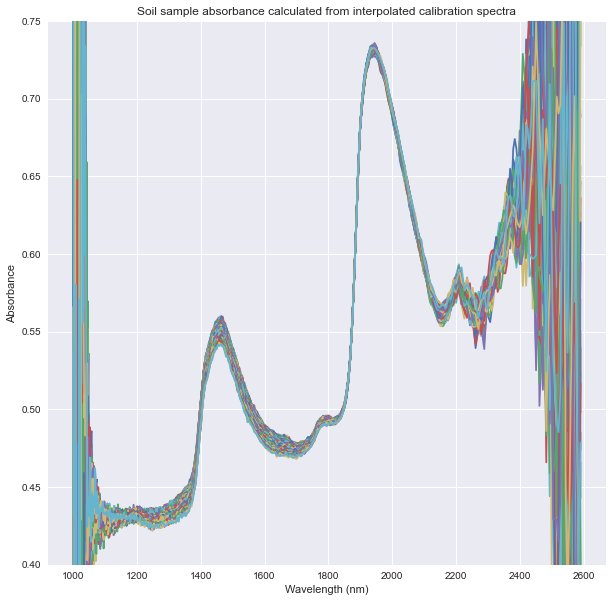

In [20]:
# plot of the absorbance calculated from the interpolated calibration spectra
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylim(0.4, 0.75)
ax.set_title("Soil sample absorbance calculated from interpolated calibration spectra")
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
for i in range(soil_raw_spectra.shape[0]):
    corrected_absorbance = calculate_absorbance_from_raw(soil_raw_spectra[i, :], white_spectra.iloc[i, :], 0)
    ax.plot(waves, corrected_absorbance)
plt.show()
plt.close()

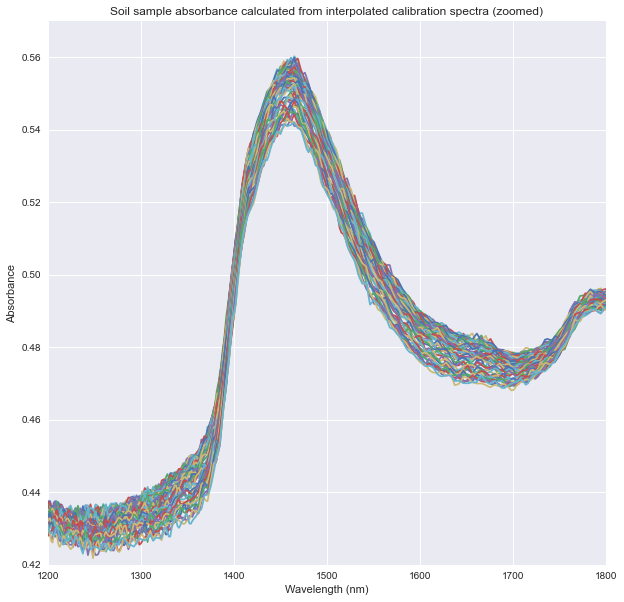

In [21]:
# Zoomed plot of the absorbance calculated from the interpolated calibration spectra
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylim(0.42, 0.57)
ax.set_xlim(1200, 1800)

ax.set_title("Soil sample absorbance calculated from interpolated calibration spectra (zoomed)")
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
for i in range(soil_raw_spectra.shape[0]):
    corrected_absorbance = calculate_absorbance_from_raw(soil_raw_spectra[i, :], white_spectra.iloc[i, :], 0)
    ax.plot(waves, corrected_absorbance)
plt.show()
plt.close()

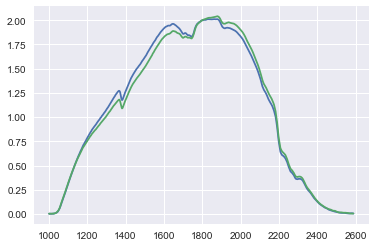

In [22]:
fig, ax = plt.subplots()
ax.plot(waves, previous_white_spectrum)
ax.plot(waves, following_white_spectrum)
plt.show()
plt.close()

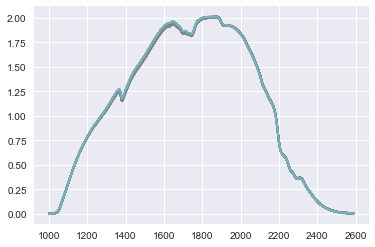

In [23]:
fig, ax = plt.subplots()
for i in range(previous_white_spectra.shape[0]):
    ax.plot(waves, previous_white_spectra[i, :])
plt.show()
plt.close()

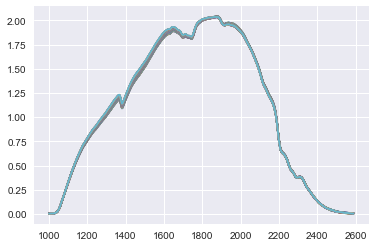

In [24]:
fig, ax = plt.subplots()
for i in range(following_white_spectra.shape[0]):
    ax.plot(waves, following_white_spectra[i, :])
plt.show()
plt.close()

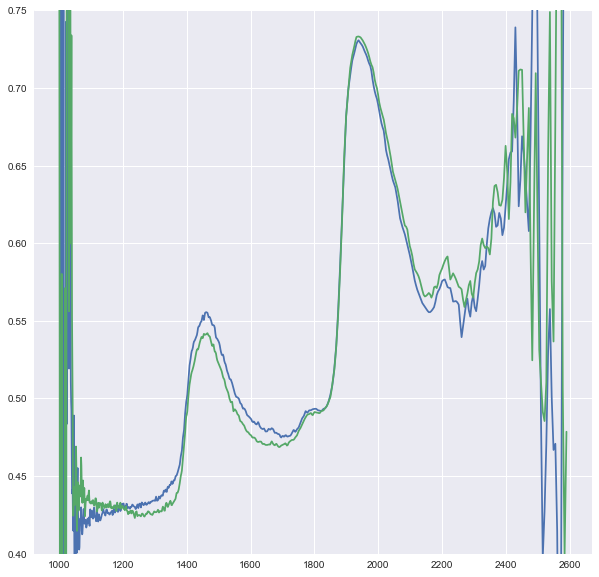

In [25]:
# first and last corrected spectra
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylim(0.4, 0.75)

corrected_absorbance1 = calculate_absorbance_from_raw(soil_raw_spectra[0, :], white_spectra.iloc[0, :], 0)
corrected_absorbance_last = calculate_absorbance_from_raw(soil_raw_spectra[-1, :], white_spectra.iloc[-1, :], 0)
ax.plot(waves, corrected_absorbance1)
ax.plot(waves, corrected_absorbance_last)
plt.show()
plt.close()

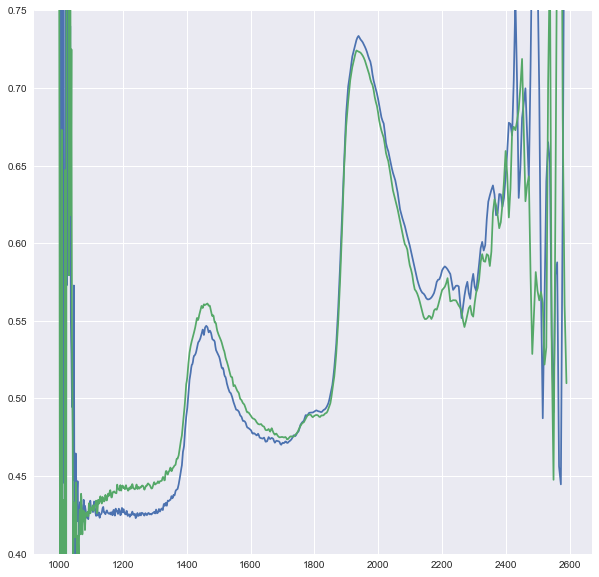

In [26]:
# first and last original spectra
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylim(0.4, 0.75)


ax.plot(waves, soil_absorbances[0, :])
ax.plot(waves, soil_absorbances[-1, :])
plt.show()
plt.close()

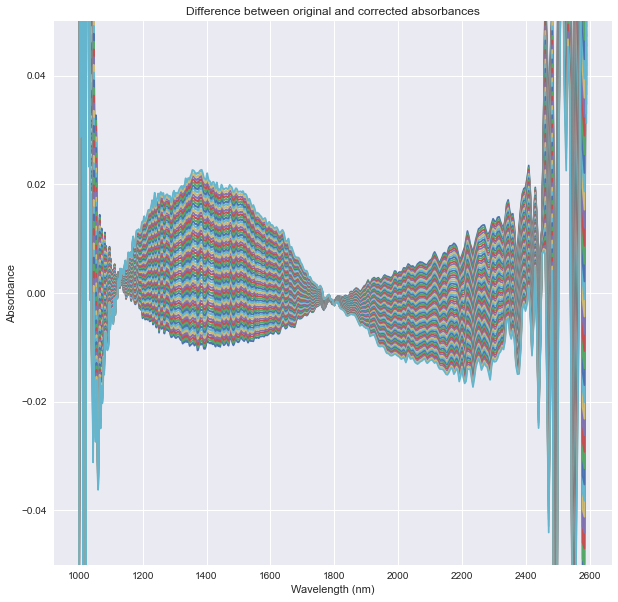

In [27]:
# plot of the difference bewteen original and interpolation 
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylim(-0.05, 0.05)
ax.set_title("Difference between original and corrected absorbances")
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
for i in range(soil_raw_spectra.shape[0]):
    corrected_absorbance = calculate_absorbance_from_raw(soil_raw_spectra[i, :], white_spectra.iloc[i, :], 0)
    ax.plot(waves, soil_absorbances[i, :] - corrected_absorbance)
plt.show()
plt.close()

# Trying again with different calibration spectra

Same soil spectra, but the chosen calibration spectra are more widely spaced in time.

In [28]:
# getting the data
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = '210422_green_tests/green_testing_210422.h5'
file = path_name + file_name
cal_path = 'session002/cal003'
soil_insertion_path = 'session002/cal003/ins020'
previous_white_blank_path = 'session002/cal003/ins019'
following_white_blank_path = 'session002/cal003/ins025'

soil_absorbances = get_ftir_insertion_absorbances(file, soil_insertion_path)
soil_timestamps = get_ftir_insertion_timestamps(file, soil_insertion_path)
soil_raw_spectra = get_ftir_insertion_raw_spectra(file, soil_insertion_path)

previous_white_spectra = get_ftir_insertion_raw_spectra(file, previous_white_blank_path)
previous_timestamps = get_ftir_insertion_timestamps(file, previous_white_blank_path)
following_white_spectra = get_ftir_insertion_raw_spectra(file, following_white_blank_path)
following_timestamps = get_ftir_insertion_timestamps(file, following_white_blank_path)

waves = get_ftir_wavelength_vector(file, cal_path)

# select the appropriate white test blank spectra to use as calibrations
previous_white_spectrum = previous_white_spectra[-1, :]
previous_timestamp = pd.Timestamp(previous_timestamps[-1], unit='us')
following_white_spectrum = following_white_spectra[0, :]
following_timestamp = pd.Timestamp(following_timestamps[0], unit='us')

# put the timestamps in the appropriate format
ts = []
for i in range(soil_timestamps.shape[0]):
    timestamp = pd.Timestamp(soil_timestamps[i], unit='us')
    ts.append(timestamp)
    
# put the timestamp for the first calibration spectrum at the head of the list
ts.insert(0, previous_timestamp)

# put the timestamp for the last calibration spectrum at the bottom of the list
ts.append(following_timestamp)

# create a dataframe to do the inserpolation in, and put the calibration spectra in the first and last rows
interp_spectra = pd.DataFrame(index=ts, columns=np.arange(0, waves.shape[0], 1), dtype=float)
interp_spectra.iloc[0, :] = previous_white_spectrum
interp_spectra.iloc[-1, :] = following_white_spectrum

# do the interpolation
interp_spectra_output = interp_spectra.interpolate()

# remove the first and last spectra from the dataframe, so only the interpolated spectra remain
white_spectra = interp_spectra_output.drop(interp_spectra_output.index[0])
white_spectra = white_spectra.drop(white_spectra.index[-1])

In [29]:
previous_timestamp

Timestamp('2021-04-22 11:19:21.716703')

In [30]:
following_timestamp

Timestamp('2021-04-22 11:36:24.059347')

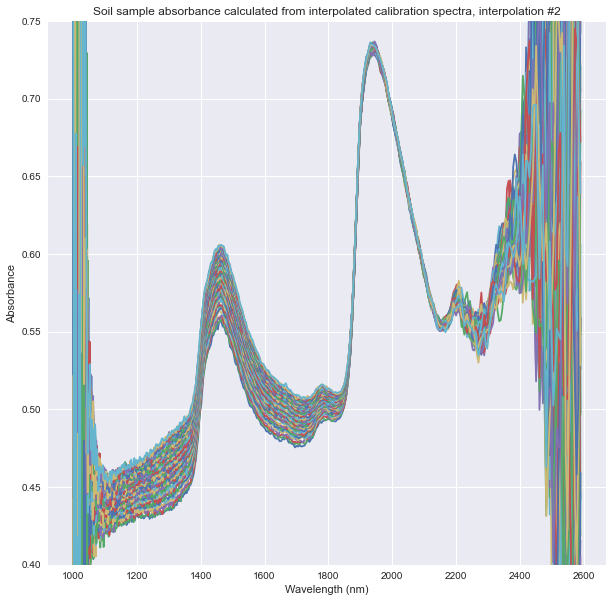

In [31]:
# plot of the absorbance calculated from the interpolated calibration spectra
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylim(0.4, 0.75)
ax.set_title("Soil sample absorbance calculated from interpolated calibration spectra, interpolation #2")
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
for i in range(soil_raw_spectra.shape[0]):
    corrected_absorbance = calculate_absorbance_from_raw(soil_raw_spectra[i, :], white_spectra.iloc[i, :], 0)
    ax.plot(waves, corrected_absorbance)
plt.show()
plt.close()

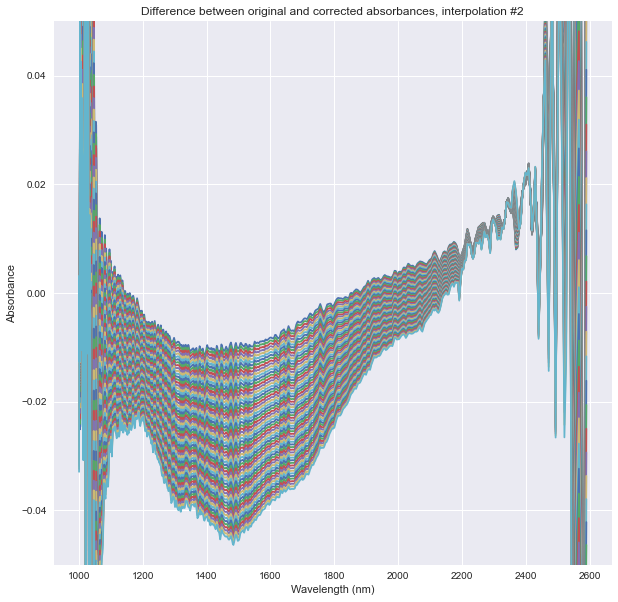

In [32]:
# plot of the difference bewteen original and interpolation #2 correction
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylim(-0.05, 0.05)
ax.set_title("Difference between original and corrected absorbances, interpolation #2")
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
for i in range(soil_raw_spectra.shape[0]):
    corrected_absorbance = calculate_absorbance_from_raw(soil_raw_spectra[i, :], white_spectra.iloc[i, :], 0)
    ax.plot(waves, soil_absorbances[i, :] - corrected_absorbance)
plt.show()
plt.close()

# Different soil samples and spectra

from 4/21/21.  Calibration spectra spaced about an hour apart.  Soil insertion spectra are from near beginning of that time period.

In [33]:
# getting the data
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = '210421_green_tests/green_testing_210421.h5'
file = path_name + file_name
cal_path = 'session001/cal002'
soil_insertion_path = 'session001/cal002/ins009'
previous_white_blank_path = 'session001/cal002/ins008'
following_white_blank_path = 'session001/cal002/ins014'

soil_absorbances = get_ftir_insertion_absorbances(file, soil_insertion_path)
soil_timestamps = get_ftir_insertion_timestamps(file, soil_insertion_path)
soil_raw_spectra = get_ftir_insertion_raw_spectra(file, soil_insertion_path)

previous_white_spectra = get_ftir_insertion_raw_spectra(file, previous_white_blank_path)
previous_timestamps = get_ftir_insertion_timestamps(file, previous_white_blank_path)
following_white_spectra = get_ftir_insertion_raw_spectra(file, following_white_blank_path)
following_timestamps = get_ftir_insertion_timestamps(file, following_white_blank_path)

waves = get_ftir_wavelength_vector(file, cal_path)

# select the appropriate white test blank spectra to use as calibrations
previous_white_spectrum = previous_white_spectra[-1, :]
previous_timestamp = pd.Timestamp(previous_timestamps[-1], unit='us')
following_white_spectrum = following_white_spectra[0, :]
following_timestamp = pd.Timestamp(following_timestamps[0], unit='us')

# put the timestamps in the appropriate format
ts = []
for i in range(soil_timestamps.shape[0]):
    timestamp = pd.Timestamp(soil_timestamps[i], unit='us')
    ts.append(timestamp)
    
# put the timestamp for the first calibration spectrum at the head of the list
ts.insert(0, previous_timestamp)

# put the timestamp for the last calibration spectrum at the bottom of the list
ts.append(following_timestamp)

# create a dataframe to do the inserpolation in, and put the calibration spectra in the first and last rows
interp_spectra = pd.DataFrame(index=ts, columns=np.arange(0, waves.shape[0], 1), dtype=float)
interp_spectra.iloc[0, :] = previous_white_spectrum
interp_spectra.iloc[-1, :] = following_white_spectrum

# do the interpolation
interp_spectra_output = interp_spectra.interpolate()

# remove the first and last spectra from the dataframe, so only the interpolated spectra remain
white_spectra = interp_spectra_output.drop(interp_spectra_output.index[0])
white_spectra = white_spectra.drop(white_spectra.index[-1])

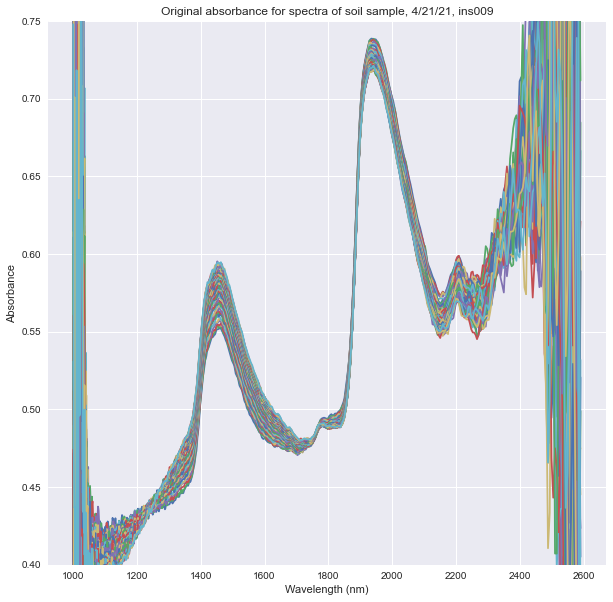

In [34]:
# plot of the orginal absorbances

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Original absorbance for spectra of soil sample, 4/21/21, ins009")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absorbance")
ax.set_ylim(0.4, 0.75)
for i in range(soil_absorbances.shape[0]):
    ax.plot(waves, soil_absorbances[i, :])
plt.show()
plt.close()

In [35]:
# select the appropriate white test blank spectra to use as calibrations
previous_white_spectrum = previous_white_spectra[-1, :]
previous_timestamp = pd.Timestamp(previous_timestamps[-1], unit='us')
following_white_spectrum = following_white_spectra[0, :]
following_timestamp = pd.Timestamp(following_timestamps[0], unit='us')

# put the timestamps in the appropriate format
ts = []
for i in range(soil_timestamps.shape[0]):
    timestamp = pd.Timestamp(soil_timestamps[i], unit='us')
    ts.append(timestamp)
    
# put the timestamp for the first calibration spectrum at the head of the list
ts.insert(0, previous_timestamp)

# put the timestamp for the last calibration spectrum at the bottom of the list
ts.append(following_timestamp)

# create a dataframe to do the inserpolation in, and put the calibration spectra in the first and last rows
interp_spectra = pd.DataFrame(index=ts, columns=np.arange(0, waves.shape[0], 1), dtype=float)
interp_spectra.iloc[0, :] = previous_white_spectrum
interp_spectra.iloc[-1, :] = following_white_spectrum

# do the interpolation
interp_spectra_output = interp_spectra.interpolate()

# remove the first and last spectra from the dataframe, so only the interpolated spectra remain
white_spectra = interp_spectra_output.drop(interp_spectra_output.index[0])
white_spectra = white_spectra.drop(white_spectra.index[-1])

In [36]:
print(previous_timestamp, following_timestamp)

2021-04-21 08:30:15.489565 2021-04-21 09:30:10.564615


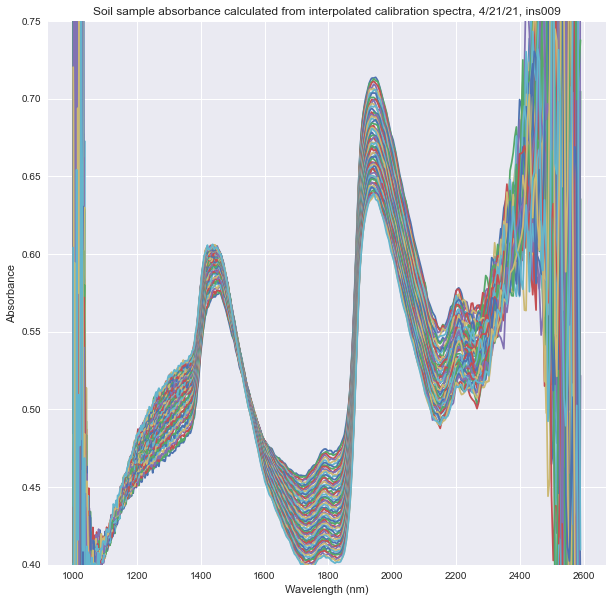

In [37]:
# plot of the absorbance calculated from the interpolated calibration spectra
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylim(0.4, 0.75)
ax.set_title("Soil sample absorbance calculated from interpolated calibration spectra, 4/21/21, ins009")
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
for i in range(soil_raw_spectra.shape[0]):
    corrected_absorbance = calculate_absorbance_from_raw(soil_raw_spectra[i, :], white_spectra.iloc[i, :], 0)
    ax.plot(waves, corrected_absorbance)
plt.show()
plt.close()

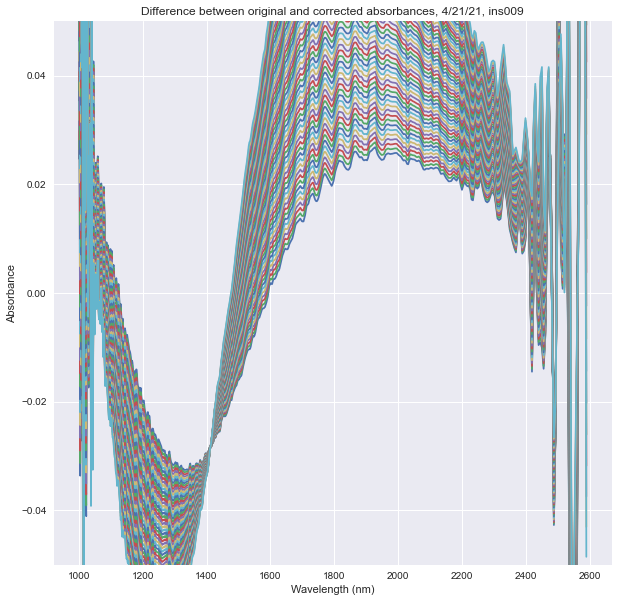

In [38]:
# plot of the difference bewteen original and interpolation #2 correction
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylim(-0.05, 0.05)
ax.set_title("Difference between original and corrected absorbances, 4/21/21, ins009")
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
for i in range(soil_raw_spectra.shape[0]):
    corrected_absorbance = calculate_absorbance_from_raw(soil_raw_spectra[i, :], white_spectra.iloc[i, :], 0)
    ax.plot(waves, soil_absorbances[i, :] - corrected_absorbance)
plt.show()
plt.close()

# Different soil samples, same spectra

from 4/21/21.  Calibration spectra spaced about an hour apart.  Soil insertion spectra are from the middle of that period.

In [39]:
# getting the data
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = '210421_green_tests/green_testing_210421.h5'
file = path_name + file_name
cal_path = 'session001/cal002'
soil_insertion_path = 'session001/cal002/ins011'
previous_white_blank_path = 'session001/cal002/ins008'
following_white_blank_path = 'session001/cal002/ins014'

soil_absorbances = get_ftir_insertion_absorbances(file, soil_insertion_path)
soil_timestamps = get_ftir_insertion_timestamps(file, soil_insertion_path)
soil_raw_spectra = get_ftir_insertion_raw_spectra(file, soil_insertion_path)

previous_white_spectra = get_ftir_insertion_raw_spectra(file, previous_white_blank_path)
previous_timestamps = get_ftir_insertion_timestamps(file, previous_white_blank_path)
following_white_spectra = get_ftir_insertion_raw_spectra(file, following_white_blank_path)
following_timestamps = get_ftir_insertion_timestamps(file, following_white_blank_path)

waves = get_ftir_wavelength_vector(file, cal_path)

# select the appropriate white test blank spectra to use as calibrations
previous_white_spectrum = previous_white_spectra[-1, :]
previous_timestamp = pd.Timestamp(previous_timestamps[-1], unit='us')
following_white_spectrum = following_white_spectra[0, :]
following_timestamp = pd.Timestamp(following_timestamps[0], unit='us')

# put the timestamps in the appropriate format
ts = []
for i in range(soil_timestamps.shape[0]):
    timestamp = pd.Timestamp(soil_timestamps[i], unit='us')
    ts.append(timestamp)
    
# put the timestamp for the first calibration spectrum at the head of the list
ts.insert(0, previous_timestamp)

# put the timestamp for the last calibration spectrum at the bottom of the list
ts.append(following_timestamp)

# create a dataframe to do the inserpolation in, and put the calibration spectra in the first and last rows
interp_spectra = pd.DataFrame(index=ts, columns=np.arange(0, waves.shape[0], 1), dtype=float)
interp_spectra.iloc[0, :] = previous_white_spectrum
interp_spectra.iloc[-1, :] = following_white_spectrum

# do the interpolation
interp_spectra_output = interp_spectra.interpolate()

# remove the first and last spectra from the dataframe, so only the interpolated spectra remain
white_spectra = interp_spectra_output.drop(interp_spectra_output.index[0])
white_spectra = white_spectra.drop(white_spectra.index[-1])

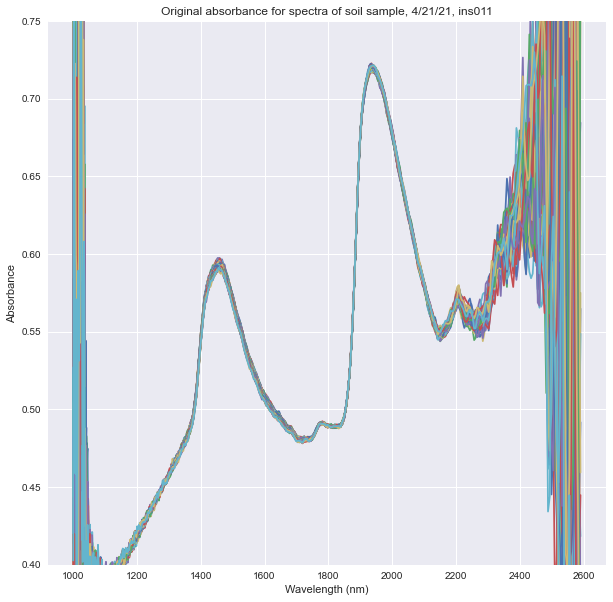

In [40]:
# plot of the orginal absorbances

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Original absorbance for spectra of soil sample, 4/21/21, ins011")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absorbance")
ax.set_ylim(0.4, 0.75)
for i in range(soil_absorbances.shape[0]):
    ax.plot(waves, soil_absorbances[i, :])
plt.show()
plt.close()

In [41]:
# select the appropriate white test blank spectra to use as calibrations
previous_white_spectrum = previous_white_spectra[-1, :]
previous_timestamp = pd.Timestamp(previous_timestamps[-1], unit='us')
following_white_spectrum = following_white_spectra[0, :]
following_timestamp = pd.Timestamp(following_timestamps[0], unit='us')

# put the timestamps in the appropriate format
ts = []
for i in range(soil_timestamps.shape[0]):
    timestamp = pd.Timestamp(soil_timestamps[i], unit='us')
    ts.append(timestamp)
    
# put the timestamp for the first calibration spectrum at the head of the list
ts.insert(0, previous_timestamp)

# put the timestamp for the last calibration spectrum at the bottom of the list
ts.append(following_timestamp)

# create a dataframe to do the inserpolation in, and put the calibration spectra in the first and last rows
interp_spectra = pd.DataFrame(index=ts, columns=np.arange(0, waves.shape[0], 1), dtype=float)
interp_spectra.iloc[0, :] = previous_white_spectrum
interp_spectra.iloc[-1, :] = following_white_spectrum

# do the interpolation
interp_spectra_output = interp_spectra.interpolate()

# remove the first and last spectra from the dataframe, so only the interpolated spectra remain
white_spectra = interp_spectra_output.drop(interp_spectra_output.index[0])
white_spectra = white_spectra.drop(white_spectra.index[-1])

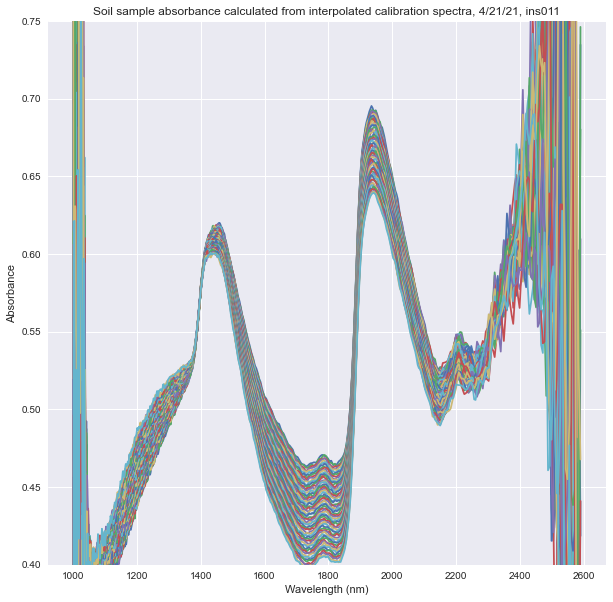

In [42]:
# plot of the absorbance calculated from the interpolated calibration spectra
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylim(0.4, 0.75)
ax.set_title("Soil sample absorbance calculated from interpolated calibration spectra, 4/21/21, ins011")
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
for i in range(soil_raw_spectra.shape[0]):
    corrected_absorbance = calculate_absorbance_from_raw(soil_raw_spectra[i, :], white_spectra.iloc[i, :], 0)
    ax.plot(waves, corrected_absorbance)
plt.show()
plt.close()

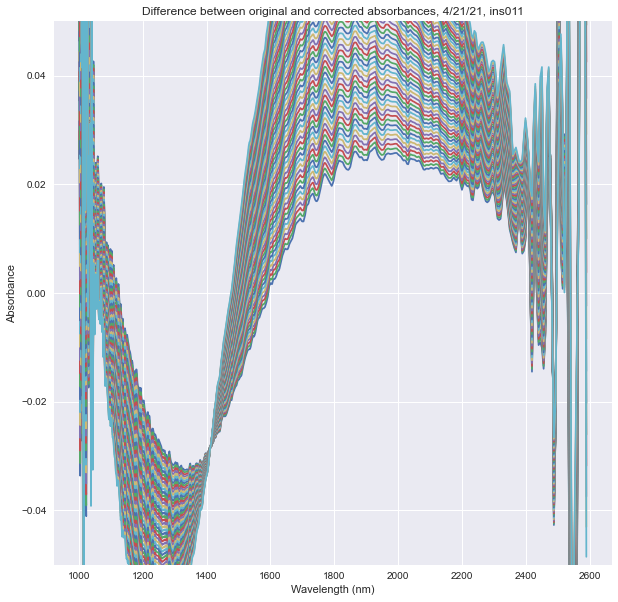

In [43]:
# plot of the difference bewteen original and interpolation #2 correction
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylim(-0.05, 0.05)
ax.set_title("Difference between original and corrected absorbances, 4/21/21, ins011")
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
for i in range(soil_raw_spectra.shape[0]):
    corrected_absorbance = calculate_absorbance_from_raw(soil_raw_spectra[i, :], white_spectra.iloc[i, :], 0)
    ax.plot(waves, soil_absorbances[i, :] - corrected_absorbance)
plt.show()
plt.close()

In [44]:
# getting the data
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = '210421_green_tests/green_testing_210421.h5'
file = path_name + file_name
cal_path = 'session001/cal002'
soil_insertion_path = 'session001/cal002/ins013'
previous_white_blank_path = 'session001/cal002/ins008'
following_white_blank_path = 'session001/cal002/ins014'

soil_absorbances = get_ftir_insertion_absorbances(file, soil_insertion_path)
soil_timestamps = get_ftir_insertion_timestamps(file, soil_insertion_path)
soil_raw_spectra = get_ftir_insertion_raw_spectra(file, soil_insertion_path)

previous_white_spectra = get_ftir_insertion_raw_spectra(file, previous_white_blank_path)
previous_timestamps = get_ftir_insertion_timestamps(file, previous_white_blank_path)
following_white_spectra = get_ftir_insertion_raw_spectra(file, following_white_blank_path)
following_timestamps = get_ftir_insertion_timestamps(file, following_white_blank_path)

waves = get_ftir_wavelength_vector(file, cal_path)

# select the appropriate white test blank spectra to use as calibrations
previous_white_spectrum = previous_white_spectra[-1, :]
previous_timestamp = pd.Timestamp(previous_timestamps[-1], unit='us')
following_white_spectrum = following_white_spectra[0, :]
following_timestamp = pd.Timestamp(following_timestamps[0], unit='us')

# put the timestamps in the appropriate format
ts = []
for i in range(soil_timestamps.shape[0]):
    timestamp = pd.Timestamp(soil_timestamps[i], unit='us')
    ts.append(timestamp)
    
# put the timestamp for the first calibration spectrum at the head of the list
ts.insert(0, previous_timestamp)

# put the timestamp for the last calibration spectrum at the bottom of the list
ts.append(following_timestamp)

# create a dataframe to do the inserpolation in, and put the calibration spectra in the first and last rows
interp_spectra = pd.DataFrame(index=ts, columns=np.arange(0, waves.shape[0], 1), dtype=float)
interp_spectra.iloc[0, :] = previous_white_spectrum
interp_spectra.iloc[-1, :] = following_white_spectrum

# do the interpolation
interp_spectra_output = interp_spectra.interpolate()

# remove the first and last spectra from the dataframe, so only the interpolated spectra remain
white_spectra = interp_spectra_output.drop(interp_spectra_output.index[0])
white_spectra = white_spectra.drop(white_spectra.index[-1])

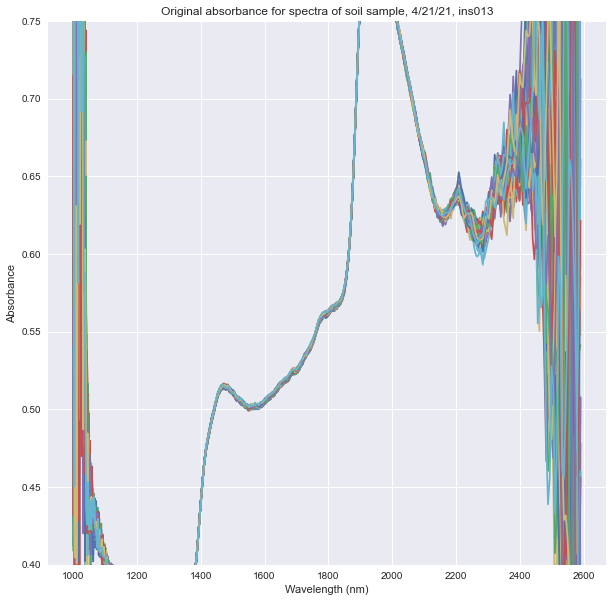

In [45]:
# plot of the orginal absorbances

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Original absorbance for spectra of soil sample, 4/21/21, ins013")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absorbance")
ax.set_ylim(0.4, 0.75)
for i in range(soil_absorbances.shape[0]):
    ax.plot(waves, soil_absorbances[i, :])
plt.show()
plt.close()

In [46]:
# select the appropriate white test blank spectra to use as calibrations
previous_white_spectrum = previous_white_spectra[-1, :]
previous_timestamp = pd.Timestamp(previous_timestamps[-1], unit='us')
following_white_spectrum = following_white_spectra[0, :]
following_timestamp = pd.Timestamp(following_timestamps[0], unit='us')

# put the timestamps in the appropriate format
ts = []
for i in range(soil_timestamps.shape[0]):
    timestamp = pd.Timestamp(soil_timestamps[i], unit='us')
    ts.append(timestamp)
    
# put the timestamp for the first calibration spectrum at the head of the list
ts.insert(0, previous_timestamp)

# put the timestamp for the last calibration spectrum at the bottom of the list
ts.append(following_timestamp)

# create a dataframe to do the inserpolation in, and put the calibration spectra in the first and last rows
interp_spectra = pd.DataFrame(index=ts, columns=np.arange(0, waves.shape[0], 1), dtype=float)
interp_spectra.iloc[0, :] = previous_white_spectrum
interp_spectra.iloc[-1, :] = following_white_spectrum

# do the interpolation
interp_spectra_output = interp_spectra.interpolate()

# remove the first and last spectra from the dataframe, so only the interpolated spectra remain
white_spectra = interp_spectra_output.drop(interp_spectra_output.index[0])
white_spectra = white_spectra.drop(white_spectra.index[-1])

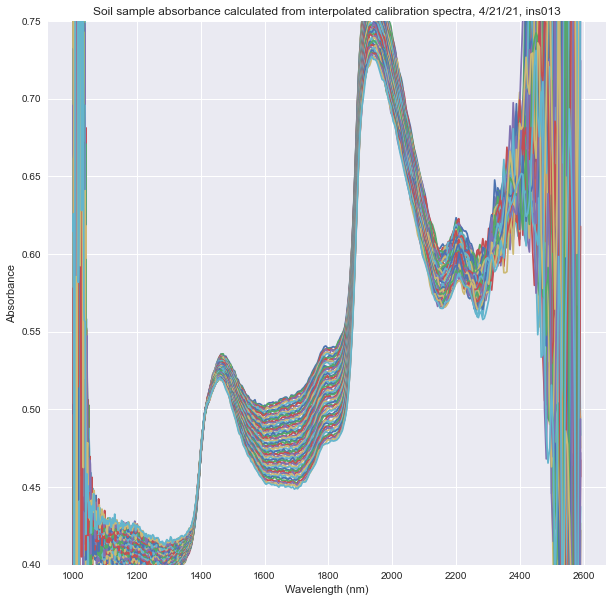

In [47]:
# plot of the absorbance calculated from the interpolated calibration spectra
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylim(0.4, 0.75)
ax.set_title("Soil sample absorbance calculated from interpolated calibration spectra, 4/21/21, ins013")
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
for i in range(soil_raw_spectra.shape[0]):
    corrected_absorbance = calculate_absorbance_from_raw(soil_raw_spectra[i, :], white_spectra.iloc[i, :], 0)
    ax.plot(waves, corrected_absorbance)
plt.show()
plt.close()

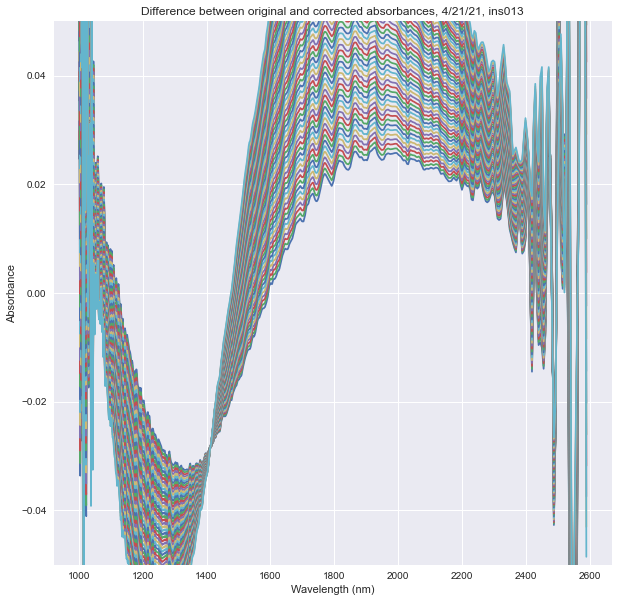

In [48]:
# plot of the difference bewteen original and interpolation #2 correction
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylim(-0.05, 0.05)
ax.set_title("Difference between original and corrected absorbances, 4/21/21, ins013")
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
for i in range(soil_raw_spectra.shape[0]):
    corrected_absorbance = calculate_absorbance_from_raw(soil_raw_spectra[i, :], white_spectra.iloc[i, :], 0)
    ax.plot(waves, soil_absorbances[i, :] - corrected_absorbance)
plt.show()
plt.close()